In [163]:
using Plots, StatsPlots
using Random
using Distributions
using StatsBase

In [275]:
S_rec = [[parse(Int,c) for c in l] for l in readlines("rec.txt")]

100-element Vector{Vector{Int64}}:
 [1, 2, 2, 1, 1, 1, 2, 1, 2, 1  …  2, 2, 1, 2, 1, 2, 2, 1, 1, 1]
 [2, 2, 1, 1, 2, 2, 1, 1, 2, 2  …  2, 1, 2, 2, 1, 2, 2, 2, 2, 1]
 [2, 2, 1, 2, 1, 2, 2, 1, 1, 2  …  2, 1, 2, 1, 2, 1, 1, 2, 2, 2]
 [1, 1, 2, 2, 1, 1, 2, 2, 2, 1  …  1, 2, 1, 2, 2, 1, 2, 2, 2, 2]
 [1, 2, 2, 1, 2, 1, 2, 2, 1, 2  …  1, 2, 2, 1, 2, 2, 1, 2, 2, 2]
 [1, 2, 2, 2, 2, 1, 2, 2, 1, 2  …  2, 2, 1, 2, 2, 1, 1, 2, 2, 2]
 [2, 2, 2, 2, 2, 2, 1, 1, 1, 1  …  1, 2, 1, 2, 1, 2, 2, 2, 2, 2]
 [2, 2, 2, 2, 2, 2, 1, 1, 1, 1  …  2, 1, 2, 2, 1, 2, 1, 2, 1, 1]
 [2, 1, 2, 2, 2, 1, 2, 2, 1, 2  …  1, 2, 1, 1, 1, 2, 2, 1, 2, 2]
 [2, 2, 1, 1, 1, 2, 2, 1, 2, 1  …  2, 2, 1, 2, 1, 2, 1, 1, 2, 2]
 ⋮
 [2, 2, 1, 1, 1, 2, 1, 2, 2, 1  …  2, 1, 2, 1, 1, 2, 1, 2, 2, 2]
 [2, 1, 2, 1, 2, 2, 1, 1, 2, 2  …  1, 1, 2, 1, 2, 1, 2, 1, 2, 2]
 [2, 1, 2, 2, 1, 1, 2, 1, 2, 1  …  2, 1, 1, 2, 1, 2, 1, 2, 1, 2]
 [2, 1, 1, 2, 2, 1, 1, 1, 2, 2  …  1, 2, 2, 1, 1, 2, 1, 2, 2, 2]
 [2, 2, 1, 1, 1, 1, 2, 2, 1, 2  …  1, 2, 2, 2, 1, 2,

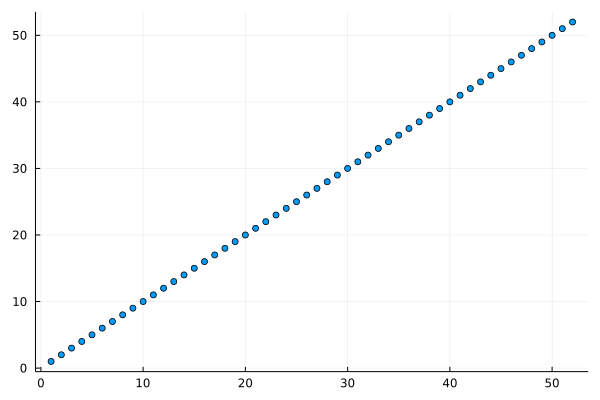

In [30]:
O = 1:52
plot(O, st=:scatter, legend=false)

In [40]:
"""
Take an ordered vector O and shuffle it according to the shuffle sequence s.
O: 52 length vector (eg 1:52)
S: 52 length vector of 1 and 2 (eg [1,1,2,1,2,2,1,2,1,2,2,1...])
    1 comes from the bottom ~half of O and are shuffled in with the left hand
    2 comes from the top ~half of O and are shuffled in with the right hand
"""
function shuffle(O,S)
    n2s = sum(S.==2)
    rh = O[1:n2s]
    lh = O[n2s+1:end]
    nd = []
    for s in S
        if s == 1
            push!(nd, popfirst!(lh))
        elseif s==2
            push!(nd, popfirst!(rh))
        else
            error("Only 1s and 2s in S")
        end
    end
    nd
end

shuffle

In [276]:
function score_shuffle(S)
    score = 1
    for i in 2:52
        if S[i] != S[i-1]
            score += 1
        end
    end
    score
end

score_shuffle (generic function with 1 method)

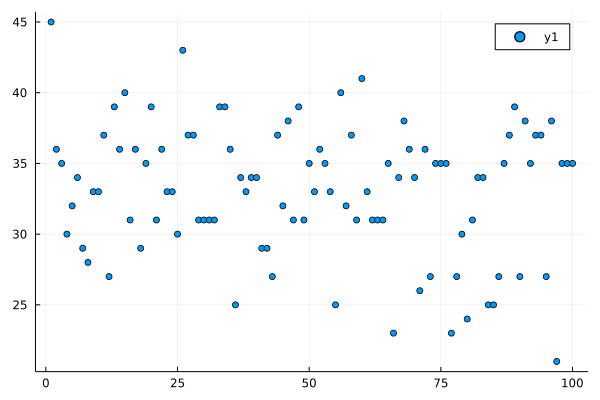

In [277]:
scores = score_shuffle.(S_rec)
plot(scores, st=:scatter)

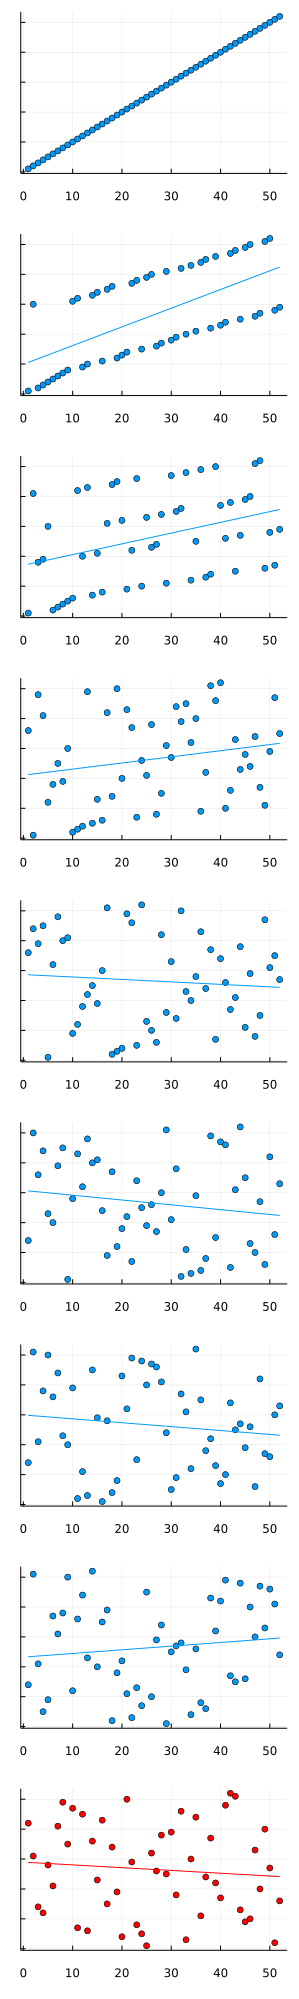

In [65]:
O = collect(1:52)
rng = MersenneTwister(1234)

ns = 7

p = [plot(O, st=:scatter, legend = false)]

for i in 1:ns
    S = rand(S_rec)
    O = shuffle(O,S)
    push!(p, plot(O, st=:scatter, legend = false, smooth=true))
end

push!(p, plot(randperm(rng,52), color=:red, st=:scatter, legend = false, smooth=true))

plot(p..., layout = (ns+2, 1), size=(300,2000))

My shuffle model

Reasonable model might be split w/ binomial distrib, then drop with likelihood proportional to number of cards left?
What about "chunks" at top and bottom?

In [278]:
S_rec

100-element Vector{Vector{Int64}}:
 [1, 2, 2, 1, 1, 1, 2, 1, 2, 1  …  2, 2, 1, 2, 1, 2, 2, 1, 1, 1]
 [2, 2, 1, 1, 2, 2, 1, 1, 2, 2  …  2, 1, 2, 2, 1, 2, 2, 2, 2, 1]
 [2, 2, 1, 2, 1, 2, 2, 1, 1, 2  …  2, 1, 2, 1, 2, 1, 1, 2, 2, 2]
 [1, 1, 2, 2, 1, 1, 2, 2, 2, 1  …  1, 2, 1, 2, 2, 1, 2, 2, 2, 2]
 [1, 2, 2, 1, 2, 1, 2, 2, 1, 2  …  1, 2, 2, 1, 2, 2, 1, 2, 2, 2]
 [1, 2, 2, 2, 2, 1, 2, 2, 1, 2  …  2, 2, 1, 2, 2, 1, 1, 2, 2, 2]
 [2, 2, 2, 2, 2, 2, 1, 1, 1, 1  …  1, 2, 1, 2, 1, 2, 2, 2, 2, 2]
 [2, 2, 2, 2, 2, 2, 1, 1, 1, 1  …  2, 1, 2, 2, 1, 2, 1, 2, 1, 1]
 [2, 1, 2, 2, 2, 1, 2, 2, 1, 2  …  1, 2, 1, 1, 1, 2, 2, 1, 2, 2]
 [2, 2, 1, 1, 1, 2, 2, 1, 2, 1  …  2, 2, 1, 2, 1, 2, 1, 1, 2, 2]
 ⋮
 [2, 2, 1, 1, 1, 2, 1, 2, 2, 1  …  2, 1, 2, 1, 1, 2, 1, 2, 2, 2]
 [2, 1, 2, 1, 2, 2, 1, 1, 2, 2  …  1, 1, 2, 1, 2, 1, 2, 1, 2, 2]
 [2, 1, 2, 2, 1, 1, 2, 1, 2, 1  …  2, 1, 1, 2, 1, 2, 1, 2, 1, 2]
 [2, 1, 1, 2, 2, 1, 1, 1, 2, 2  …  1, 2, 2, 1, 1, 2, 1, 2, 2, 2]
 [2, 2, 1, 1, 1, 1, 2, 2, 1, 2  …  1, 2, 2, 2, 1, 2,

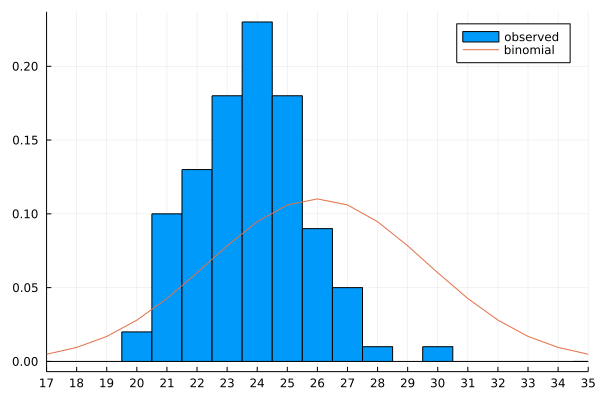

In [279]:
# Investigate split
rec1 = [sum(s.==1) for s in S_rec]
histogram(rec1, bins=16.5:1:35.5, xticks=17:35, label="observed", normalize=:pdf)
plot!(Binomial(52), st=:line, xlims=(17,35), label = "binomial")

Fraction that starts with 2: 0.8
Fraction that ends with 2: 0.81


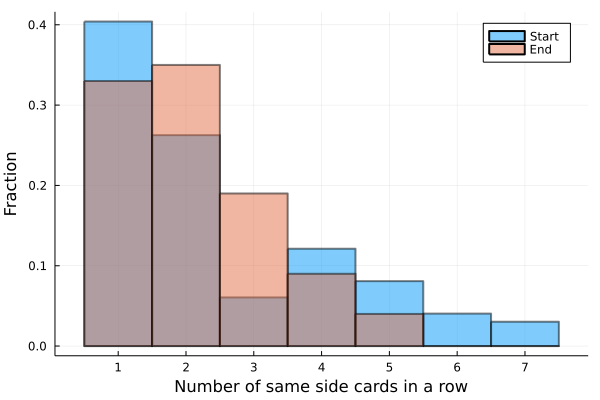

In [281]:
# Investigate end chunks
println("Fraction that starts with 2: ", count([s[1]   for s in S_rec].==2)/length(S_rec))
println("Fraction that ends with 2: "  , count([s[end] for s in S_rec].==2)/length(S_rec))

A = []
Z = []
for S in S_rec
    e = S[1]
    push!(A,0)
    for s in S
        if s == e
            A[end]+=1
        else
            break
        end
    end
    
    e = S[end]
    push!(Z,0)
    for s in reverse(S)
        if s == e
            Z[end]+=1
        else
            break
        end
    end
end

plot(A,  label="Start", st=:hist, bins=0.5:7.5, lw=2, alpha=0.5, norm=:pdf)
plot!(Z, label="End",   st=:hist, bins=0.5:7.5, lw=2, alpha=0.5, norm=:pdf,
    xlabel="Number of same side cards in a row",
    ylabel="Fraction")


In [261]:
BINOM = Binomial(52)
function gsr_shuffle()
    cut = rand(BINOM,1)[1]
    nl = cut
    nr = 52 - cut

    out = Int[]
    for _ in 1:52
        pl = nl / (nl + nr)
        if rand() < pl
            push!(out, 1)
            nl -= 1
        else
            push!(out, 2)
            nr -= 1
        end
    end
    reverse(out)
end

gsr_shuffle (generic function with 1 method)

In [262]:
GSR_rec = [gsr_shuffle() for _ in 1:1000]

1000-element Vector{Vector{Int64}}:
 [1, 1, 1, 2, 1, 1, 2, 1, 2, 2  …  2, 2, 1, 2, 2, 2, 1, 1, 1, 1]
 [2, 1, 1, 2, 1, 2, 1, 2, 2, 2  …  1, 1, 1, 2, 1, 2, 1, 1, 2, 2]
 [1, 2, 2, 1, 2, 1, 2, 1, 1, 2  …  1, 1, 2, 1, 1, 1, 1, 2, 2, 1]
 [2, 1, 1, 1, 2, 1, 2, 2, 1, 2  …  1, 2, 1, 1, 2, 2, 1, 2, 2, 1]
 [2, 1, 1, 2, 1, 1, 2, 1, 1, 2  …  1, 2, 1, 1, 2, 1, 2, 2, 2, 2]
 [1, 2, 1, 1, 2, 1, 2, 2, 2, 2  …  1, 1, 2, 1, 2, 2, 2, 2, 1, 2]
 [1, 1, 1, 2, 1, 2, 2, 1, 1, 2  …  2, 1, 2, 2, 1, 2, 2, 1, 1, 1]
 [2, 1, 1, 2, 1, 1, 2, 2, 2, 2  …  1, 2, 2, 2, 2, 1, 2, 2, 2, 1]
 [1, 1, 1, 1, 2, 1, 1, 2, 2, 1  …  2, 1, 2, 1, 2, 2, 1, 2, 2, 1]
 [1, 2, 2, 1, 2, 1, 2, 1, 1, 2  …  2, 1, 1, 1, 1, 2, 1, 1, 2, 1]
 ⋮
 [2, 1, 2, 2, 2, 1, 2, 1, 1, 1  …  1, 1, 2, 1, 1, 2, 1, 1, 1, 2]
 [1, 1, 2, 1, 2, 2, 2, 2, 2, 2  …  1, 1, 2, 2, 2, 2, 2, 1, 2, 1]
 [2, 1, 2, 1, 2, 2, 1, 2, 1, 1  …  1, 2, 2, 1, 1, 2, 1, 2, 1, 1]
 [2, 2, 1, 1, 1, 2, 2, 2, 1, 2  …  1, 2, 1, 1, 2, 1, 1, 1, 2, 2]
 [1, 1, 2, 2, 2, 1, 1, 2, 1, 2  …  2, 1, 2, 2, 2, 2

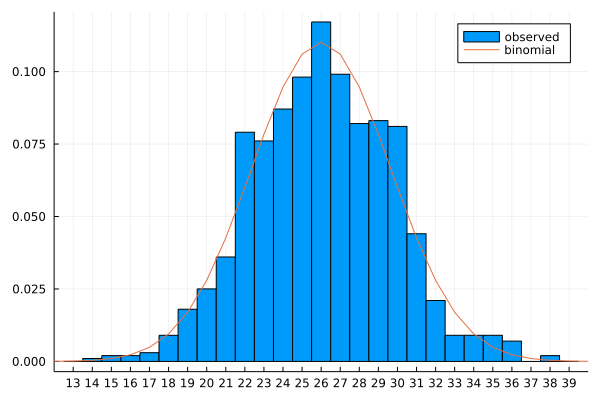

In [263]:
# Investigate split
rec_gsr = [sum(s.==1) for s in GSR_rec]
histogram(rec_gsr, bins=12.5:1:39.5, xticks=13:39, label="observed", normalize=:pdf)
plot!(Binomial(52), st=:line, xlims=(12,40), label = "binomial")

Fraction that starts with 2: 0.482
Fraction that ends with 2: 0.49


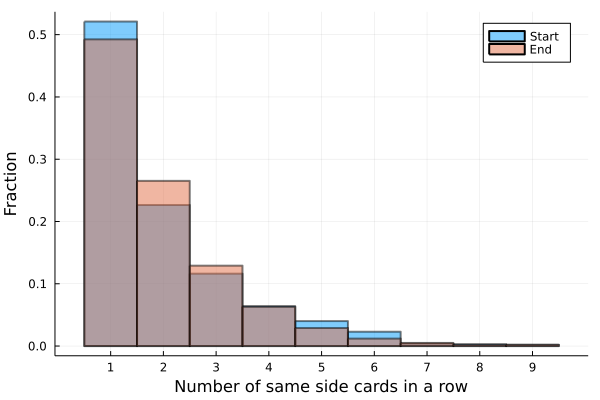

In [264]:
# Investigate end chunks
println("Fraction that starts with 2: ", count([s[1]   for s in GSR_rec].==2)/length(GSR_rec))
println("Fraction that ends with 2: "  , count([s[end] for s in GSR_rec].==2)/length(GSR_rec))

A = []
Z = []
for S in GSR_rec
    e = S[1]
    push!(A,0)
    for s in S
        if s == e
            A[end]+=1
        else
            break
        end
    end
    
    e = S[end]
    push!(Z,0)
    for s in reverse(S)
        if s == e
            Z[end]+=1
        else
            break
        end
    end
end

plot(A,  label="Start", st=:hist, bins=0.5:9.5, lw=2, alpha=0.5, norm=:pdf)
plot!(Z, label="End",   st=:hist, bins=0.5:9.5, lw=2, alpha=0.5, norm=:pdf,
    xlabel="Number of same side cards in a row",
    ylabel="Fraction",
    xticks = 1:9)


In [287]:
# What's my brier? Split up into 1/4 of deck to see where I'm good and bad
probs = Float64[]
outcs = Bool[]
cards = Int[]
for S in S_rec
    for (i,s) in enumerate(S)
        nl = count(S[1:i].==2)
        nr = count(S[1:i].==1)
        prob = nl/(nl+nr)
        outc = (s == 2)
        push!(probs, prob)
        push!(outcs, outc)
        push!(cards, nl+nr)
    end
end

In [288]:
edges = 0:0.1:1.0
binC  = 0.05:0.1:0.95

h  = fit(Histogram, probs, edges)
binindices = StatsBase.binindex.(Ref(h), probs)

outF = Float64[]
for i in 1:length(binC)
    idx = binindices .== i
    push!(outF, count(outcs[idx]) / count(idx))
end

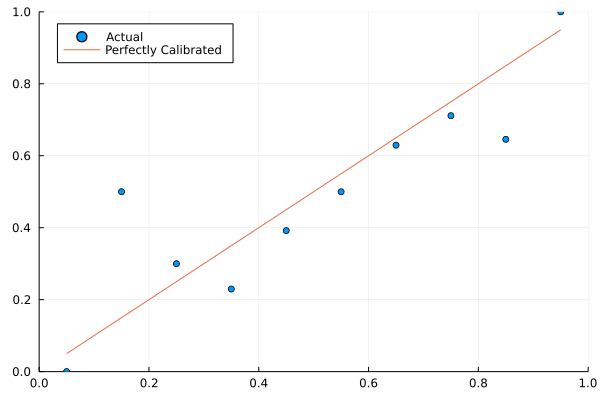

In [289]:
scatter(binC, outF, label="Actual", legend=:topleft, xlims=(0,1), ylims=(0,1))
plot!(binC, binC, label="Perfectly Calibrated")

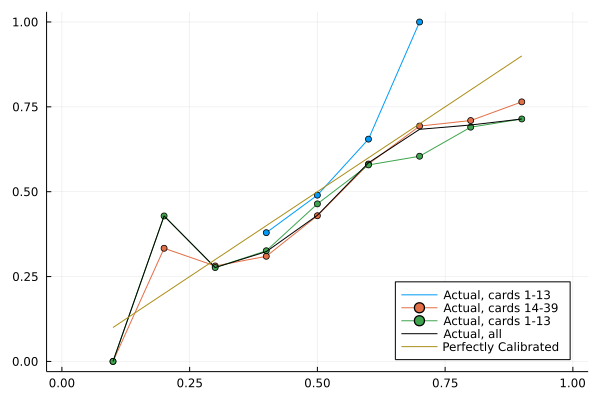

In [290]:
# What's my brier? Split up into 1/4 of deck to see where I'm good and bad
probs = Float64[]
outcs = Bool[]
cards = Int[]
for S in S_rec
    for (i,s) in enumerate(S)
        nl = count(S[1:i].==2)
        nr = count(S[1:i].==1)
        prob = nl/(nl+nr)
        outc = (s == 2)
        push!(probs, prob)
        push!(outcs, outc)
        push!(cards, nl+nr)
    end
end

edges = 0.05:0.1:0.95
binC  = 0.1:0.1:0.9

h  = fit(Histogram, probs, edges)
binindices = StatsBase.binindex.(Ref(h), probs)


outF = Float64[]
for i in 1:length(binC)
    idx = (binindices .== i) .& (cards .> 39)
    push!(outF, count(outcs[idx]) / count(idx))
end
p = plot(binC, outF, markershape=:circle, label="Actual, cards 1-13", xlims=(-0.03,1.03), ylims=(-0.03,1.03))

outF = Float64[]
for i in 1:length(binC)
    idx = (binindices .== i) .& (cards .> 13 .& cards .< 40)
    push!(outF, count(outcs[idx]) / count(idx))
end
plot!(p, binC, outF, markershape=:circle, label="Actual, cards 14-39")

outF = Float64[]
for i in 1:length(binC)
    idx = (binindices .== i) .& (cards .< 14)
    push!(outF, count(outcs[idx]) / count(idx))
end
plot!(p, binC, outF, markershape=:circle, label="Actual, cards 1-13")

outF = Float64[]
for i in 1:length(binC)
    idx = (binindices .== i) 
    push!(outF, count(outcs[idx]) / count(idx))
end
plot!(p, binC, outF, color=:black, label="Actual, all")


plot!(p, binC, binC, label="Perfectly Calibrated", legend=:bottomright)

# save("test.png",p)
p

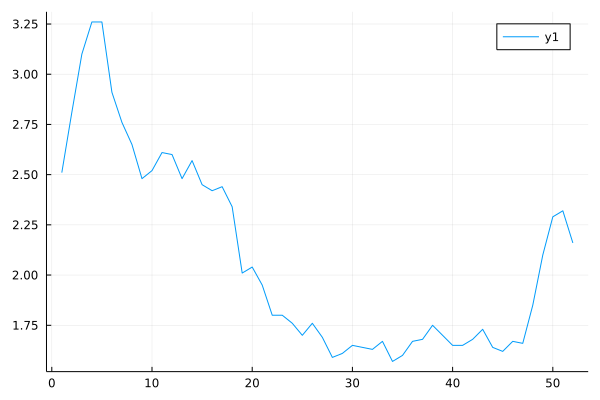

In [291]:
#Chance a card is in a run? - show EV run length and chance left/right
run_rec = []
for S in S_rec
    this_run_rec = ones(Int,52)
    current_run_idx = falses(52)
    current_run_idx[1] = true
    current_run_len = 1
    for i in 2:52
        if S[i] == S[i-1]
            current_run_idx[i] = true
            current_run_len += 1
            this_run_rec[current_run_idx] .= current_run_len
        else
            current_run_len = 1
            current_run_idx = falses(52)
            current_run_idx[i] = true
        end
    end
    push!(run_rec, this_run_rec)
end

run_rec
run_ev = [mean([s[i] for s in run_rec]) for i in 1:52]
plot(run_ev)

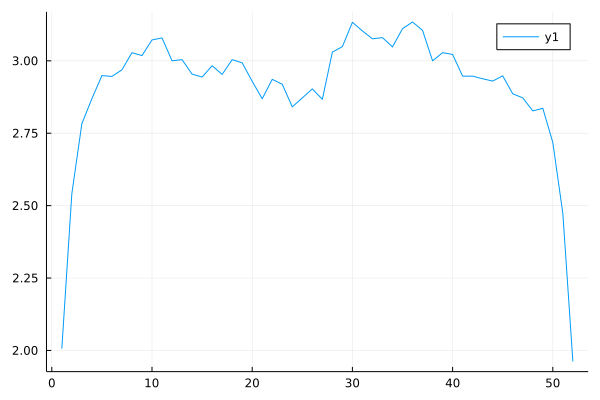

In [265]:
run_rec = []
for S in GSR_rec
    this_run_rec = ones(Int,52)
    current_run_idx = falses(52)
    current_run_idx[1] = true
    current_run_len = 1
    for i in 2:52
        if S[i] == S[i-1]
            current_run_idx[i] = true
            current_run_len += 1
            this_run_rec[current_run_idx] .= current_run_len
        else
            current_run_len = 1
            current_run_idx = falses(52)
            current_run_idx[i] = true
        end
    end
    push!(run_rec, this_run_rec)
end

run_rec
run_ev = [mean([s[i] for s in run_rec]) for i in 1:52]
plot(run_ev)

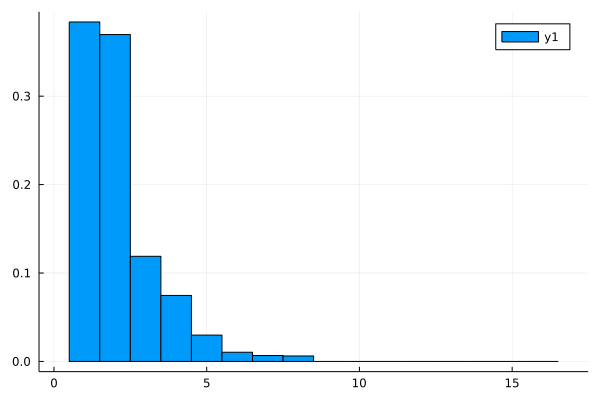

In [292]:
histogram(vcat(run_rec...), bins = 0.5:1:16.5, norm=:pdf)

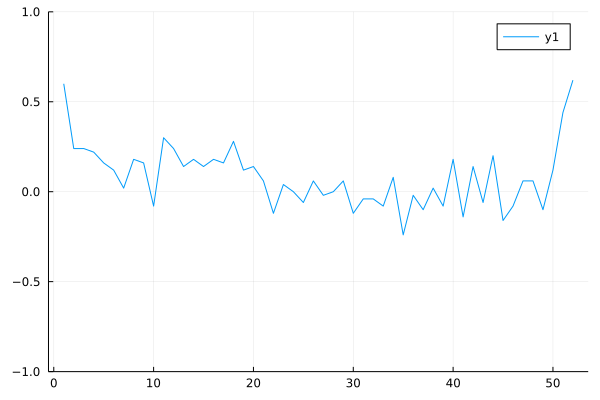

In [293]:
side_ev = 2 .* ([mean([s[i] for s in S_rec]) for i in 1:52] .- 1.5)
plot(side_ev, ylims = (-1, 1))

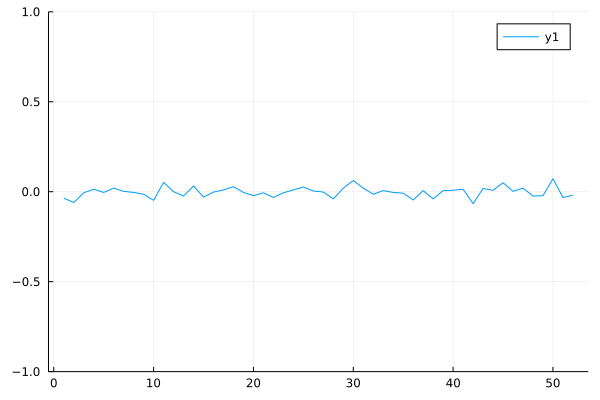

In [274]:
side_ev = 2 .* ([mean([s[i] for s in GSR_rec]) for i in 1:52] .- 1.5)
plot(side_ev, ylims = (-1, 1))

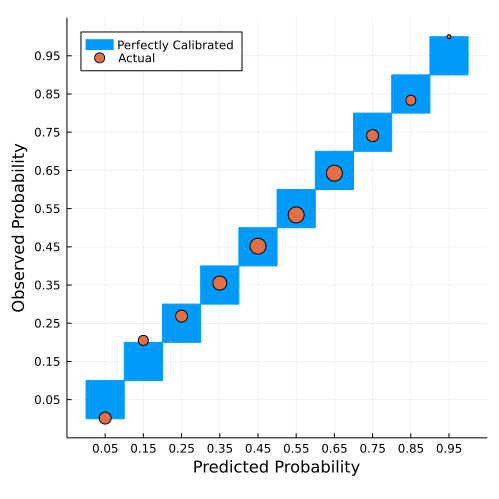

In [344]:
# What's GSR brier? Split up into 1/4 of deck to see where I'm good and bad
probs = Float64[]
outcs = Bool[]
cards = Int[]
for S in GSR_rec
    for (i,s) in enumerate(S)
        nl = count(S[1:i].==2)
        nr = count(S[1:i].==1)
        prob = nl/(nl+nr)
        outc = (s == 2)
        push!(probs, prob)
        push!(outcs, outc)
        push!(cards, nl+nr)
    end
end

edges = 0:0.1:1.0
binC  = 0.05:0.1:0.95

h  = fit(Histogram, probs, edges)
binindices = StatsBase.binindex.(Ref(h), probs)

outF = Float64[]
dps  = Int[]
for i in 1:length(binC)
    idx = binindices .== i
    push!(outF, count(outcs[idx]) / count(idx))
    push!(dps, count(idx))
end


X = vcat([[x,x,NaN] for x in binC]...)
Y = vcat([[x-0.05,x+0.05,NaN] for x in binC]...)
X = vcat([[x-0.05,x-0.05,x+0.05,x+0.05,x-0.05,NaN] for x in binC]...)
Y = vcat([[x-0.05,x+0.05,x+0.05,x-0.05,x-0.05,NaN] for x in binC]...)

plot(X, Y, fill=true, label="Perfectly Calibrated", aspect_ratio=1, size=(500,500),
    xlabel = "Predicted Probability",
    ylabel = "Observed Probability",
    xticks = binC, yticks=binC)

scatter!(binC, outF, markersize=log.(dps/maximum(dps)).+10, label="Actual", legend=:topleft, xlims=(-0.05,1.05), ylims=(-0.05,1.05))


Show 3 Draw 1 advantage (using ML models?)

Premo

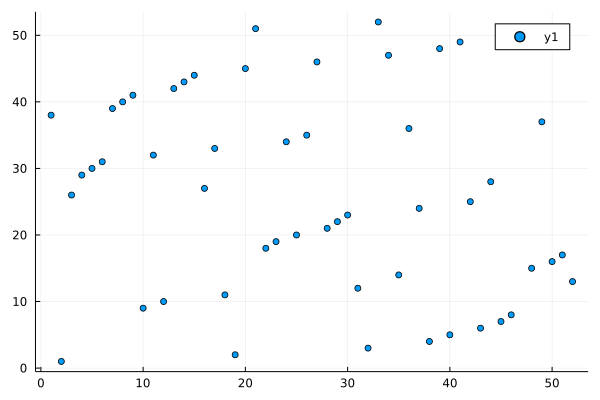

In [404]:
O0 = collect(1:52)
O1 = shuffle(O0, gsr_shuffle())
O2 = shuffle(O1, gsr_shuffle())
O3 = shuffle(O2, gsr_shuffle())
scatter(O3)

In [453]:
function rising_sequences(Oin)
    
    O = copy(Oin)

    rseq = []
    c_seq = Int[]
    seq_class = zeros(Int,52)
    i = 1
    val = 1

    while val < 53

        if i > length(O)
            i = 1
            push!(rseq, c_seq)
            c_seq = Int[]
        end

        if O[i] == val
            push!(c_seq, popat!(O,i))
            seq_class[Oin .== val] .= length(rseq) + 1
            val += 1
            continue
        else
            i+=1
        end
        
    end

    push!(rseq, c_seq)
    
    return rseq, seq_class
end



rising_sequences (generic function with 1 method)

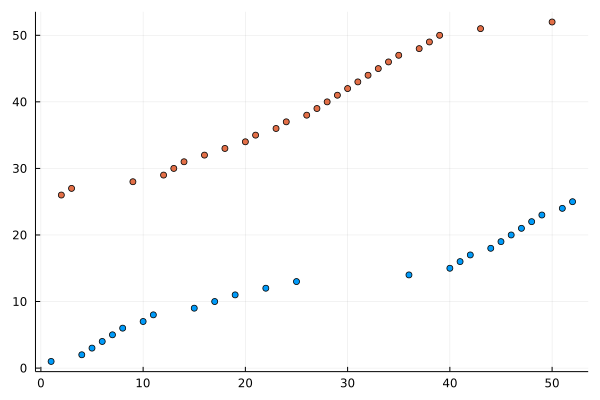

In [459]:
rs, sq = rising_sequences(O1)
scatter(O1, color=sq, legend = false)


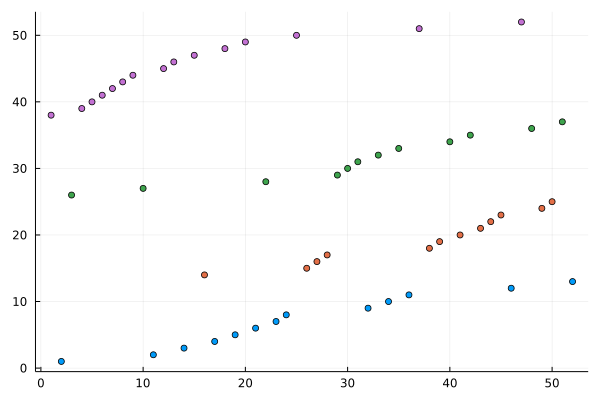

In [460]:
rs, sq = rising_sequences(O2)
scatter(O2, color=sq, legend = false)

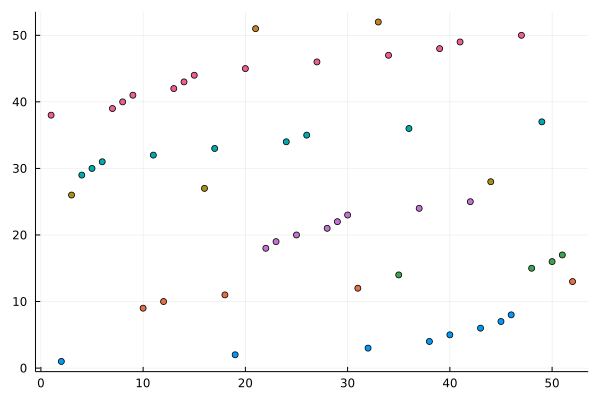

In [461]:
rs, sq = rising_sequences(O3)
scatter(O3, color=sq, legend = false)

Top card actual: 17
Top card guess: 17


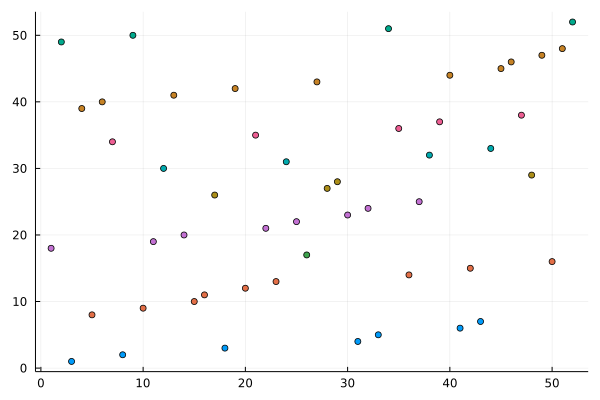

In [476]:
O0 = collect(1:52)
O1 = shuffle(O0, gsr_shuffle())
O2 = shuffle(O1, gsr_shuffle())
O3 = shuffle(O2, gsr_shuffle())
tc = O3[1]
Opremo = insert!(O3[2:end], rand(1:52), O3[1])
rs, sq = rising_sequences(Opremo)

sl = [length(s) for s in rs]
ss = argmin(sl)
ssl = sl[ss]


println("Top card actual: ", tc)
if ssl == 1
    println("Top card guess: ", rs[ss][1])
else
    println("Can't guess")
end

scatter(Opremo, color=sq, legend = false)


In [471]:
argmin([length(s) for s in rs])

8

In [472]:
rs

8-element Vector{Any}:
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
 [11, 12, 13, 14, 15, 16]
 [17, 18, 19, 20, 21]
 [22, 23, 24, 25, 26, 27, 28]
 [29, 30, 31, 32, 33, 34, 35]
 [36, 37, 38, 39, 40, 41, 42]
 [43, 44, 45, 46, 47, 48, 49]
 [50, 51, 52]